In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
import astropy.units as u
import astropy.constants

In [2]:
# Code used to extract a section off the Youtube video audio
#fs, x = wavfile.read('/home/daniel/EMM/EMM_Hope live from Mars at 20m Antenna Bochum-Observatory (320 kbps).wav')
## selection in seconds
#start = 8000 - 150
#length = 300
#end = start + length
#x_cut = x[start * fs : end * fs]
#x_cut.astype('int16').tofile('bochum_EMM_MOI_audio_8ksps.i16')

In [3]:
x = np.fromfile('bochum_EMM_MOI_audio_8ksps.i16', dtype = 'int16')/2**15
fs = 8000

In [4]:
f0 = 800 # frequency at which the signal is centre before MOI
lo = np.exp(-1j*2*np.pi*np.arange(x.size)*f0/fs)
y = x * lo

In [5]:
steps = 16
def waterfall(y, NFFT = 2**13, steps = steps):
    w = np.blackman(NFFT)
    fs = list()
    for j in range(steps):
        y_r = y[j*NFFT//steps:]
        y_r = y_r[:y_r.size//NFFT*NFFT]
        f0 = np.fft.fftshift(np.abs(np.fft.fft(w * y_r.reshape((-1,NFFT))))**2, axes = -1)
        fs.append(f0)
    l = np.min([f.shape[0] for f in fs])
    f = np.stack([f[:l] for f in fs], axis = 1).reshape((-1, NFFT))
    fdB = 10*np.log10(f)
    return fdB

In [6]:
fdB = waterfall(y)

In [7]:
def plot_waterfall(fdB, tstart, tstop, title, span = 500):
    plt.figure(figsize = (12,8), facecolor = 'w')
    tstep = fdB.shape[1]/(fs*steps)
    plt.imshow(fdB[:,fdB.shape[1]//2-span//2:fdB.shape[1]//2+span//2].T[::-1,tstart:tstop],
               aspect = 'auto', vmin = -5, vmax = 15,
               extent = [tstart * tstep, tstop * tstep,
                         f0 - span//2*fs/fdB.shape[1], f0 + span//2*fs/fdB.shape[1]])
    plt.xlabel('Time (s)')
    plt.ylabel('Audio frequency (Hz)')
    plt.title(title)

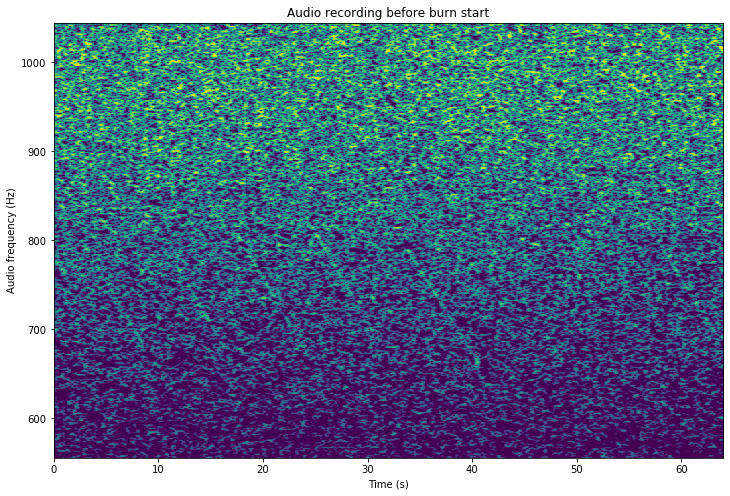

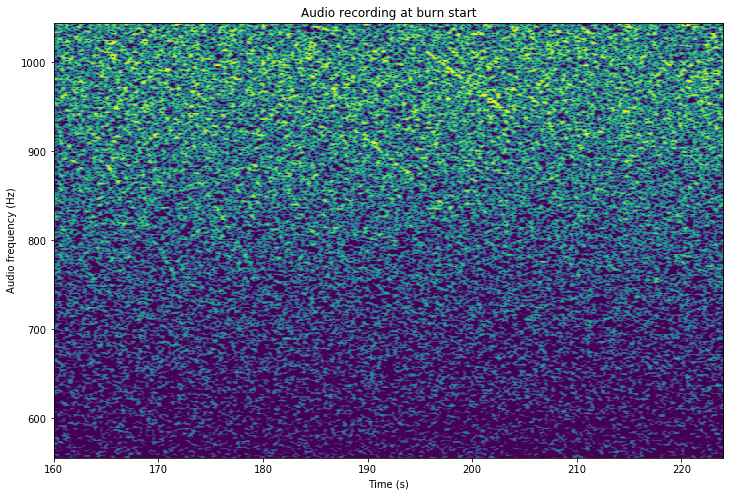

In [8]:
plot_waterfall(fdB, 0, 1000, 'Audio recording before burn start')
plot_waterfall(fdB, 2500, 3500, 'Audio recording at burn start')

In [9]:
dfdt0 = -19.5
drift_limit = 77
t_offset = 3.5
f = f0 + (dfdt0 * (np.arange(x.size) / fs - t_offset) + drift_limit) % (2*drift_limit) - drift_limit
lo2 = np.exp(-1j*2*np.pi*np.cumsum(f)/fs)
y2 = x * lo2
fdB2 = waterfall(y2)

In [10]:
def plot_waterfall_spectrum(fdB, tstart, tstop, title, span = 1000,
                            freqstart = 0, freqstop = 600, freqtstart = 0, freqtstop = 650):
    fig, axs = plt.subplots(1, 2, figsize = (12,8), facecolor = 'w',
                           sharey = True,
                           gridspec_kw={'width_ratios':[3,1]})
    tstep = fdB.shape[1]/(fs*steps)
    fstep = fs/fdB.shape[1]
    fsel = slice(fdB.shape[1]//2-span//2, fdB.shape[1]//2+span//2)
    faxis = f0 + np.arange(fsel.start, fsel.stop)*fstep - fs/2
    fdB_cut = fdB[:,fsel].T[::-1,tstart:tstop][freqstart:freqstop]
    axs[0].imshow(fdB_cut,
               aspect = 'auto', vmin = -5, vmax = 15,
               extent = [tstart * tstep, tstop * tstep,
                         faxis[::-1][freqstop], faxis[::-1][freqstart]])
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Audio frequency (Hz)')
    line = freqtstop if freqtstart == 0 else freqtstart
    line_t = (line + tstart)*tstep
    axs[0].axvline(x = line_t, linestyle = '--', color = 'white')
    f = 10*np.log10(np.sum(10**(0.1*fdB_cut[:,freqtstart:freqtstop]), axis = 1))
    axs[1].plot(f, faxis[::-1][freqstart:freqstop], color = 'black')
    axs[1].set_ylim(faxis[::-1][freqstop], faxis[::-1][freqstart])
    axs[1].set_xlabel('Power spectral density (dB)')
    axs[0].set_title(title + f'; Burn start at t = {line_t} seconds')
    plt.tight_layout()

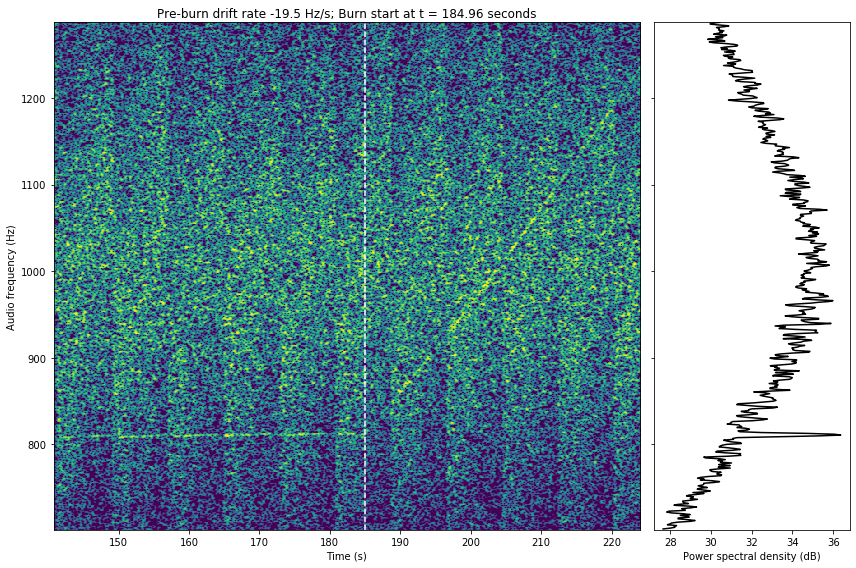

In [11]:
plot_waterfall_spectrum(fdB2, 2200, 3500,
                        f'Pre-burn drift rate {dfdt0} Hz/s', freqtstop = 690)

In [26]:
dfdt1 = -8
drift_limit = 77
t_offset2 = 185
f3 = f + (dfdt1 - dfdt0) * (np.arange(x.size) / fs - t_offset2)
lo3 = np.exp(-1j*2*np.pi*np.cumsum(f3)/fs)
y3 = x * lo3
fdB3 = waterfall(y3)

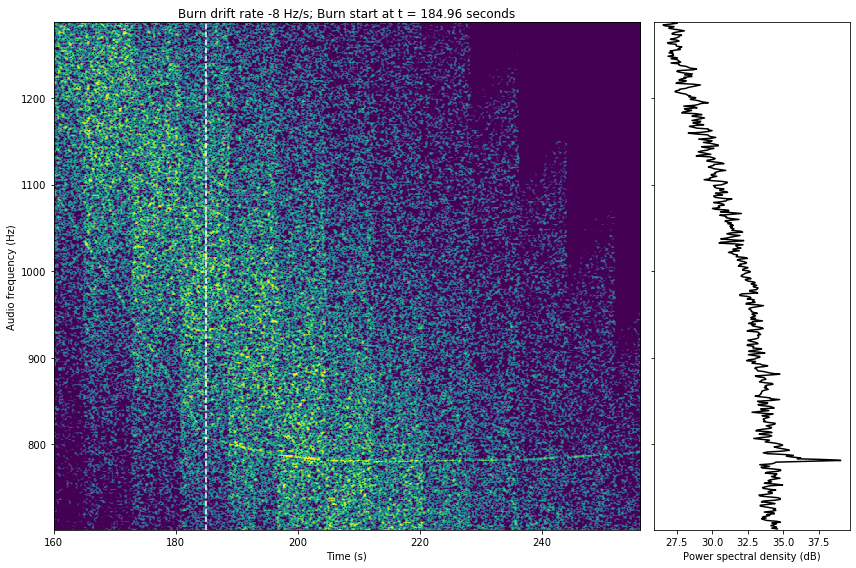

In [30]:
plot_waterfall_spectrum(fdB3, 2500, 4000,
                        f'Burn drift rate {dfdt1} Hz/s', freqtstart = 390, freqtstop = 4000 - 2500)

In [38]:
carrier_freq = 8402.2e6 * u.Hz
los_acceleration = -(dfdt1 - dfdt0)*u.Hz/u.s/carrier_freq * astropy.constants.c
los_acceleration

<Quantity -0.41032269 m / s2>

In [40]:
m0 = (550 + 700) * u.kg
F = 720 * u.N
acceleration_theory = -(F/m0).to(u.m/u.s**2)
acceleration_theory

<Quantity -0.576 m / s2>

In [49]:
r_EarthMJ2000Eq = np.array([130330585.64953, 126238996.46220, 59628757.000369])
v_MarsMJ2000Eq = np.array([3.0089284193084, 3.4721585566306, -0.9571476249084])
ur = r_EarthMJ2000Eq / np.sqrt(np.sum(r_EarthMJ2000Eq**2))
uv = v_MarsMJ2000Eq / np.sqrt(np.sum(v_MarsMJ2000Eq**2))
los_projection = np.dot(ur, uv)
los_projection

0.8628326854240876

In [50]:
los_acceleration/los_projection

<Quantity -0.47555302 m / s2>

In [51]:
-(los_acceleration/los_projection*m0).to(u.N)

<Quantity 594.44126929 N>